In [1]:
from tensorflow.keras.models import load_model
from utility.loss import seg_loss, dice_coef, iou_coef
from sklearn.preprocessing import binarize
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
os.environ["CUDA_VISIBLE_DEVICES"]="0"

2023-04-30 17:16:11.231561: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def npy_loader(maindir, rtype, seed: int = 2):
    # get list of files in directory
    directory = maindir + '*.npy'
    pathlist = glob.glob(directory)
    random.Random(seed).shuffle(pathlist)
    
    # iterate over list of files
    for path in pathlist:
        array = np.load(path)
        
        # get image and normalize it between -1 and 1
        img = array[:, :, 0]
        img = (img * 2) - 1
        
        # get image mask
        if rtype == 'elli':
            mask = array[:, :, 1]
        else:
            mask = binarize(array[:, :, 1])
            
        yield img[..., np.newaxis], mask[..., np.newaxis]
        
def plot_image(img, mask, pred_mask, i):
    # get mask alpha arrays
    mask_alpha = np.divide(mask[:, :, 0], 1.7)
    pred_mask_alpha = np.divide(pred_mask[0, :, :, 0], 1.7)
    
    # plot image and masks
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    fig.suptitle(f'Image {i}', fontsize=14)
    
    axes[0].imshow(img, cmap='gray')
    axes[0].imshow(mask, alpha=mask_alpha)
    axes[0].set_title('Original Mask')
    
    axes[1].imshow(img, cmap='gray')
    axes[1].imshow(pred_mask[0, :, :, 0], alpha=pred_mask_alpha)
    axes[1].set_title('Predicted Mask')
    
    plt.show()

In [3]:
# load dataset
test_dir = '/home/careinfolab/unet_mammo/images/pos_norm/test/'

rect_test_loader = npy_loader(test_dir, rtype='rect')

In [4]:
# load model
model_path = './saved_models/deep_unet_test101_rect2'

model = load_model(model_path, compile=False)
model.compile(loss=[seg_loss], metrics=[dice_coef, iou_coef])
model.summary()

2023-04-30 17:16:20.468062: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-30 17:16:20.511277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-30 17:16:20.511499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-30 17:16:20.511511: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-30 17:16:20.513550: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-30 17:16:20.513576: I tensorflow/stream_executor/pl

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 832, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 416, 32) 1600        input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 256, 208, 64) 2400        conv2d[0][0]                     
__________________________________________________________________________________________________
residual_block (ResidualBlock)  (None, 256, 208, 64) 14592       separable_conv2d[0][0]           
____________________________________________________________________________________________

2023-04-30 17:16:33.080526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-30 17:16:33.096903: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3800060000 Hz
2023-04-30 17:16:33.601561: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-30 17:16:34.067466: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2023-04-30 17:16:34.656836: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-30 17:16:35.044502: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


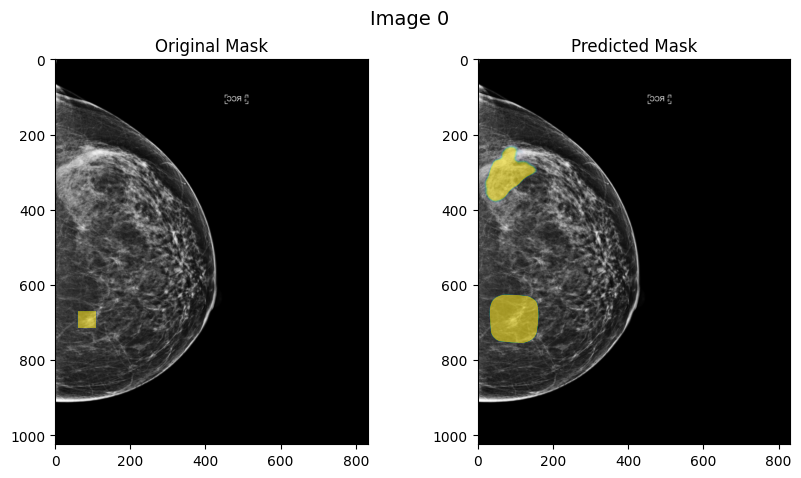

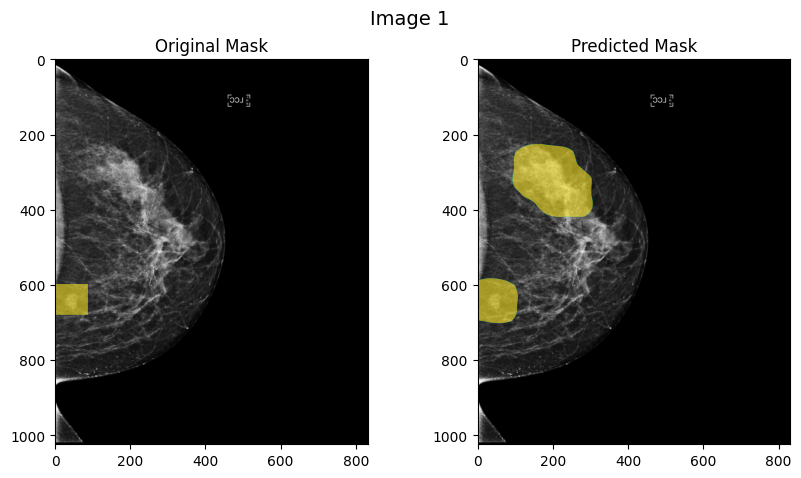

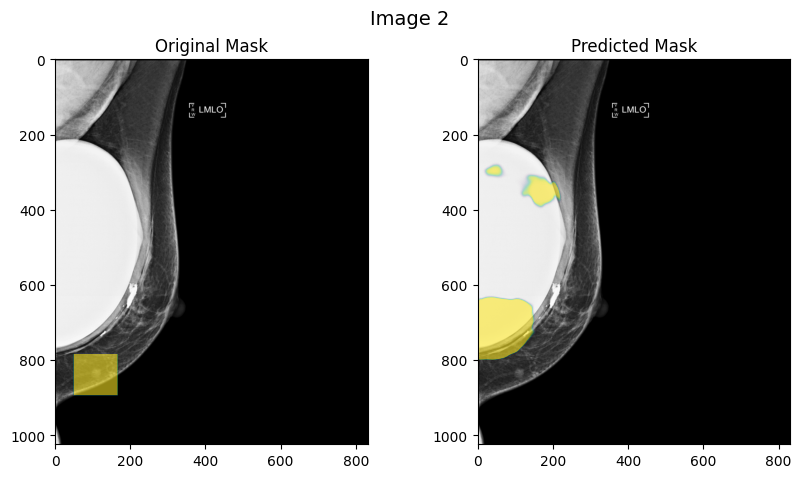

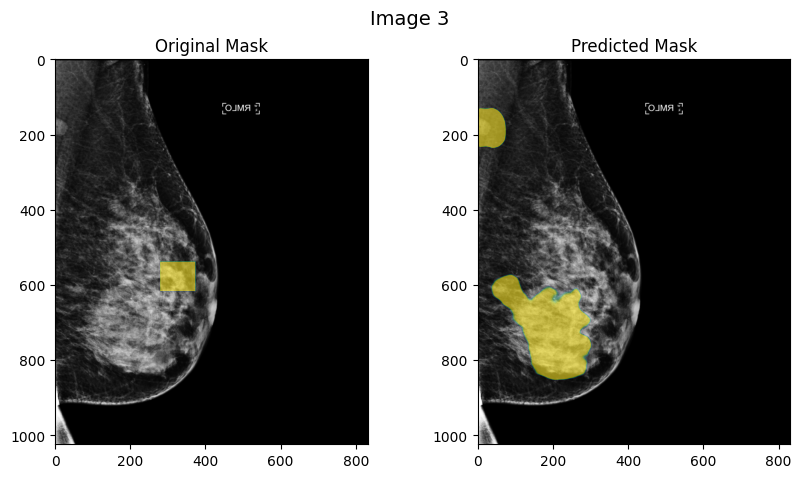

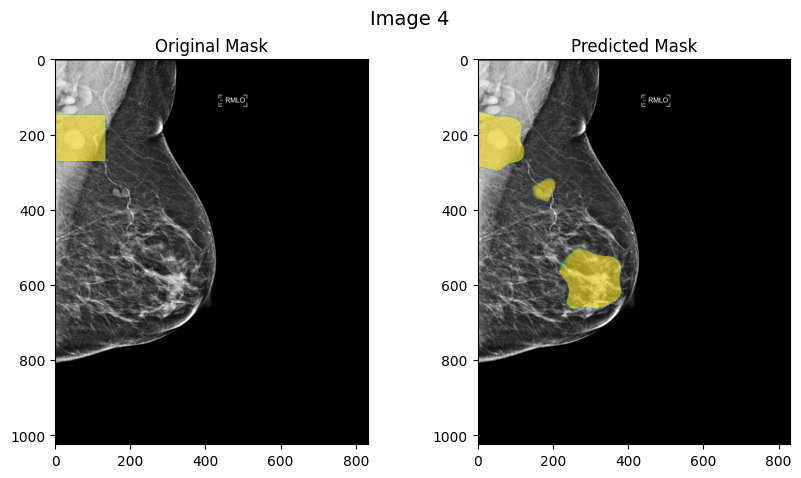

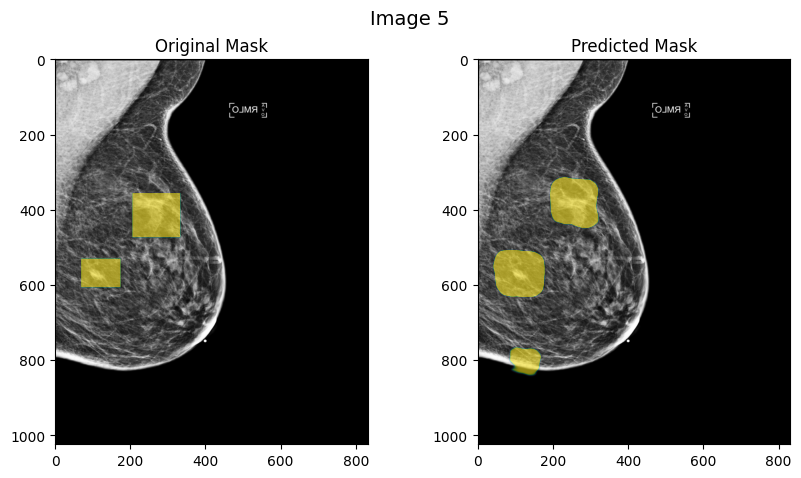

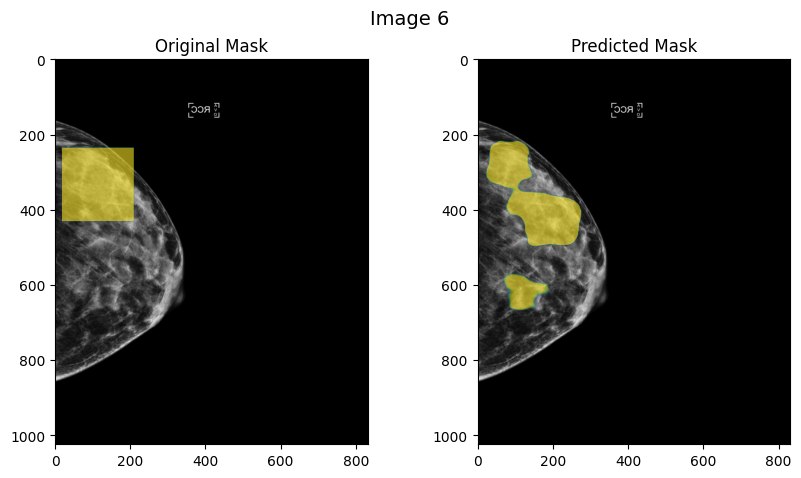

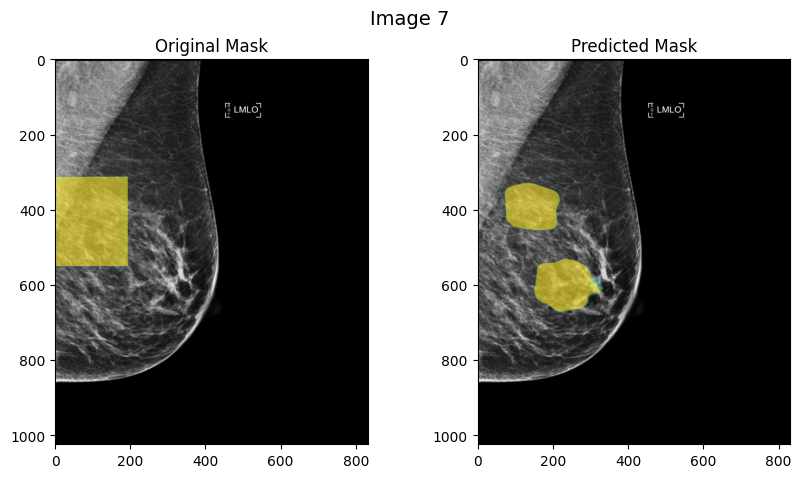

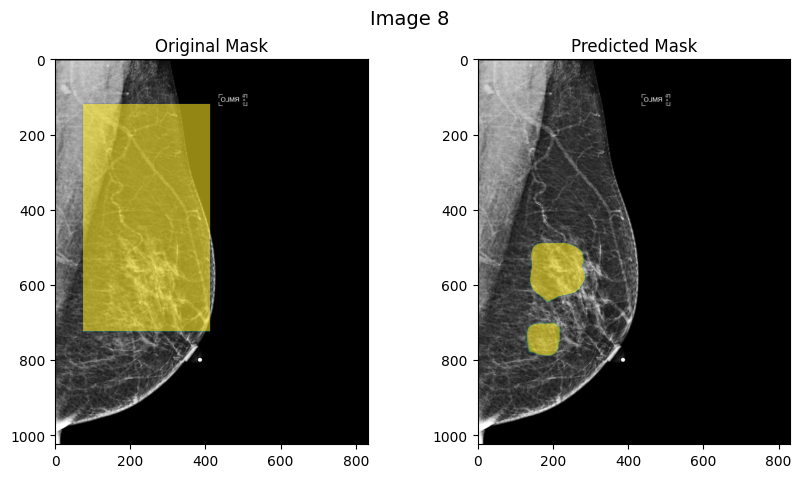

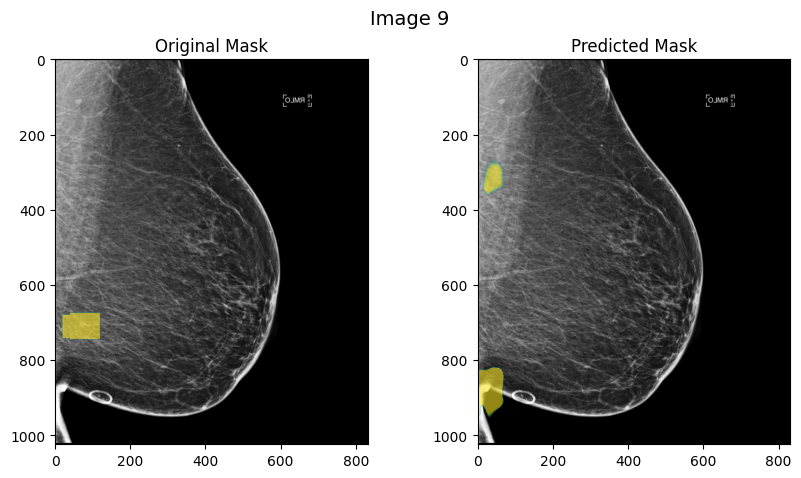

In [5]:
n = 10

for i, data in enumerate(rect_test_loader):
    if i >= n:
        break
            
    img, mask = data
    
    # get prediction
    pred_mask = model.predict(img[None, ...])
    
    # plot original and predicted masks
    plot_image(img, mask, pred_mask, i)